# Titanic Dataset

## Lib Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
from sklearn.metrics import classification_report

In [15]:
RANDOM_STATE = 123

In [16]:
import os
import sys
from pathlib import Path

current_dir = os.getcwd()
kaggle_root_dir = Path(current_dir).parent
kaggle_lib_dir = os.path.join(kaggle_root_dir, 'kaggle_lib/src')
sys.path.append(kaggle_lib_dir)

In [17]:
from kaggle_lib.titanic.preprocessing import preprocess_titanic_dataset
from kaggle_lib.models.model_helpers import grid_search_rf, grid_search_xgb, grid_search_dt, grid_search_bc, grid_search_lr
from kaggle_lib.models.classification_metrics import get_classification_metrics, display_confusion_matrix

## 1. Dataset Loading

In [18]:
train_df = pd.read_csv('train.csv')

In [19]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### 1.1 Missing Dataset Analysis

In [21]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Three columns are missing values within the training dataset:

* Age: 177 missing values which is significant as age was likely a significant factor in the survival on the Titanic.
* Cabin: missing substantial values but not likely significant so can also be removed.
* Embarked: only missing two entries so can probably just be removed.

In [22]:
empty_age_mask = (train_df['Age'].isna())

In [23]:
empty_age_df = train_df[empty_age_mask]
empty_age_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


### 1.2 Title Extraction

It may be worth investigating whether there titles in the names can be used to help fill in missing age values.

Start by creating a list of components of the name string split by ','.

In [24]:
passenger_names = train_df['Name'].str.split(',')
passenger_names

0                             [Braund,  Mr. Owen Harris]
1      [Cumings,  Mrs. John Bradley (Florence Briggs ...
2                              [Heikkinen,  Miss. Laina]
3        [Futrelle,  Mrs. Jacques Heath (Lily May Peel)]
4                            [Allen,  Mr. William Henry]
                             ...                        
886                             [Montvila,  Rev. Juozas]
887                      [Graham,  Miss. Margaret Edith]
888          [Johnston,  Miss. Catherine Helen "Carrie"]
889                             [Behr,  Mr. Karl Howell]
890                               [Dooley,  Mr. Patrick]
Name: Name, Length: 891, dtype: object

Next create a list of titles by splitting the second list value by ' ' and taking the first entry.

In [25]:
titles = [passenger_name[1].lstrip().split(' ')[0][:-1] for passenger_name in passenger_names]

In [26]:
print(f"num titles {len(titles)}")

num titles 891


Converting to a set.

In [27]:
title_set = set(titles)
print(f"num unique titles: {len(title_set)}")

num unique titles: 17


## 3. Feature Engineering

Based on discussions and research, the below features will be engineered:

* FamilySize: this represents the combination of SibSp and Parch column.
* Title: will used a refactored version of the code from 2.3 to convert names to Titles.
* LabelEncoding: label encode Title, Sex and Embarked columns.

Furthermore the below columns will be dropped:

* 'PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Cabin'

**Custom Feature Engineering Methods**

In [28]:
preprocess_titanic_dataset(train_df)
train_df.head()

TypeError: preprocess_titanic_dataset() missing 2 required positional arguments: 'mean_age_by_titles' and 'titles'

In [ ]:
train_df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Title         0
FamilySize    0
dtype: int64

In [ ]:
len(train_df)

891

## 4. X and y split

In [ ]:
Y_COLUMN = 'Survived'

In [ ]:
y = train_df[Y_COLUMN]
X = train_df.drop(Y_COLUMN, axis=1)

In [ ]:
X.head()

,Pclass,Sex,Age,Fare,Title,FamilySize
0,3,1,0.271174,0.014151,11,1
1,1,0,0.472229,0.139136,12,1
2,3,0,0.321438,0.015469,8,0
3,1,0,0.434531,0.103644,12,1
4,3,1,0.434531,0.015713,11,0


In [ ]:
y.value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

## 5. Train Test Split

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
shuffle = StratifiedShuffleSplit(
    random_state=RANDOM_STATE,
    n_splits=1,
    test_size=0.3
)
train_index, test_index = next(shuffle.split(X, y))

In [ ]:
X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

## 6. Model Hyperparameter Training

In this section I am going to train and perform hyperparameter tuning on a variety of models, perform evaluation, and then choose the best model for the predictions.

In [ ]:
grid_search_res = [
    grid_search_xgb(X_train, y_train),
    grid_search_bc(X_train, y_train),
    grid_search_rf(X_train, y_train),
    grid_search_dt(X_train, y_train),
    grid_search_lr(X_train, y_train),
]

/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:875: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:881: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:875: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:881: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/home/mbarbaric/

In [ ]:
model_names = ['XGB Classifier', 'Bagging Classifier', 'Random Forest Classifier', 'Decision Tree Classifier', 'Logistic Regression']
model_dict = dict(zip(model_names, [model for _, model in grid_search_res]))

## 7. Model Training and Evaluation

Evaluating model XGB Classifier


              precision    recall  f1-score   support

           0       0.95      0.87      0.91       179
           1       0.78      0.90      0.83        89

    accuracy                           0.88       268
   macro avg       0.86      0.89      0.87       268
weighted avg       0.89      0.88      0.88       268



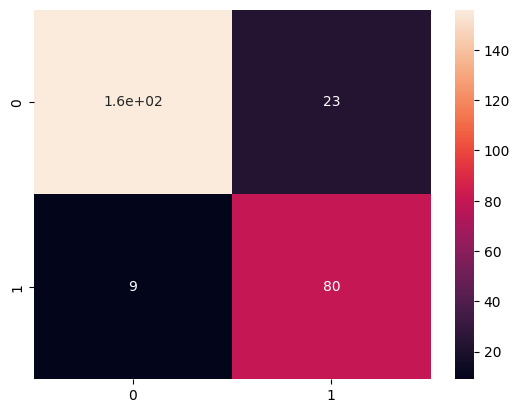





Evaluating model Bagging Classifier


              precision    recall  f1-score   support

           0       0.96      0.95      0.95       167
           1       0.91      0.93      0.92       101

    accuracy                           0.94       268
   macro avg       0.94      0.94      0.94       268
weighted avg       0.94      0.94      0.94       268



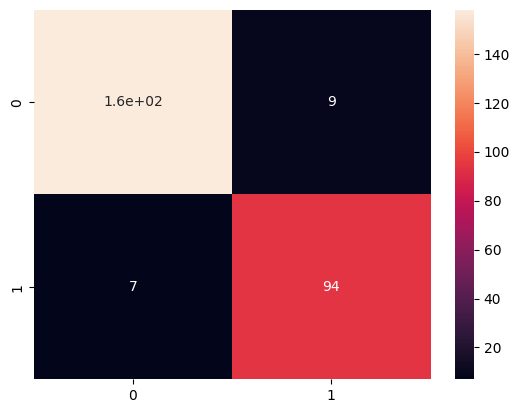





Evaluating model Random Forest Classifier


              precision    recall  f1-score   support

           0       0.95      0.90      0.93       174
           1       0.83      0.91      0.87        94

    accuracy                           0.91       268
   macro avg       0.89      0.91      0.90       268
weighted avg       0.91      0.91      0.91       268



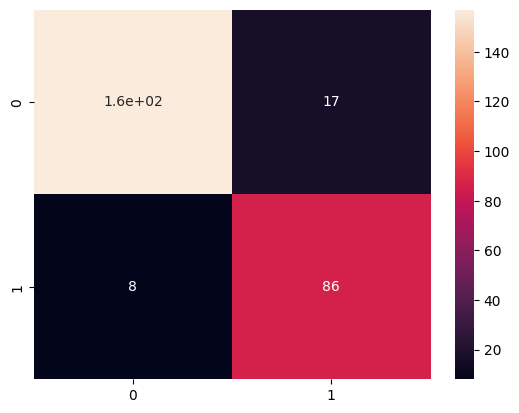





Evaluating model Decision Tree Classifier


              precision    recall  f1-score   support

           0       0.91      0.88      0.90       170
           1       0.81      0.85      0.83        98

    accuracy                           0.87       268
   macro avg       0.86      0.86      0.86       268
weighted avg       0.87      0.87      0.87       268



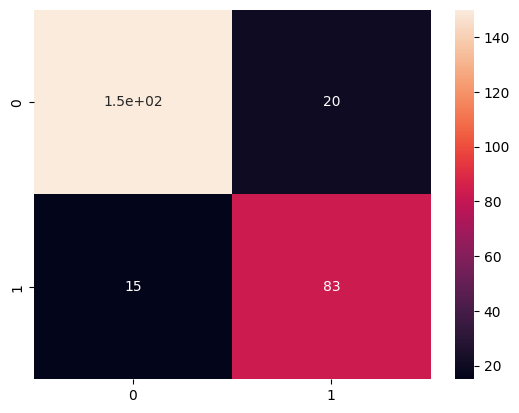





Evaluating model Logistic Regression


              precision    recall  f1-score   support

           0       0.84      0.82      0.83       170
           1       0.70      0.73      0.72        98

    accuracy                           0.79       268
   macro avg       0.77      0.78      0.77       268
weighted avg       0.79      0.79      0.79       268



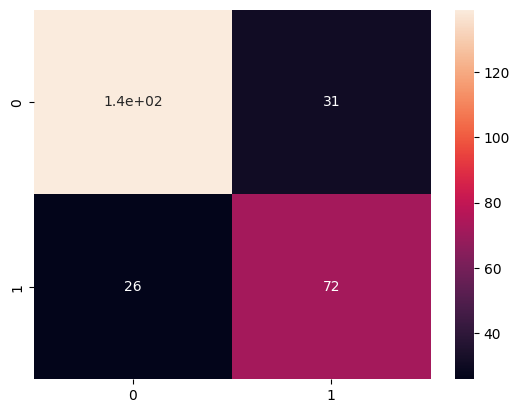

In [ ]:
for model_name, model in model_dict.items():
    print(f"Evaluating model {model_name}")
    y_pred2 = model.predict(X_test)
    print("\n")
    print(classification_report(y_pred2, y_test))
    display_confusion_matrix(y_pred2, y_test)
    print("\n\n\n")

Overall, the Random Forest Classifier performed the best, with an average f1 score of 84%. Interestingly enough, all of the models suffered when predicting True values which is worth investigating why the model is sufferering when trying to predict passengers who survived.

## 8. Model Selection, Training and Kaggle Prediction Generation and Submissions

The next section reads the test dataset, applies the same preprocessing as for the training set, runs predictions and reformats csv file so it can be submitted to Kaggle.

In [ ]:
#TODO: Convert models to dict to make this clearer
selected_model = model_dict['XGB Classifier']

In [ ]:
test_df = pd.read_csv('test.csv')

In [ ]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
X_val = test_df.copy()
preprocess_dataset(X_val)

In [ ]:
X_val.head()

,Pclass,Sex,Age,Fare,Title,FamilySize
0,3,1,0.452723,0.015282,5,0
1,3,0,0.617566,0.013663,6,1
2,2,1,0.815377,0.018909,5,0
3,3,1,0.353818,0.016908,5,0
4,3,0,0.287881,0.023984,6,2


In [ ]:
y_val = selected_model.predict(X_val)

In [ ]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_val})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


Reviewing the mosst accurate prediction of 75% to compare how these submissions fare.

In [ ]:
y_true_val = pd.read_csv('submission_best.csv')
y_true_val

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
print(classification_report(y_true_val['Survived'], submission['Survived']))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       255
           1       0.79      0.61      0.69       163

    accuracy                           0.78       418
   macro avg       0.79      0.75      0.76       418
weighted avg       0.79      0.78      0.78       418



In [ ]:
submission.to_csv('submission.csv', index=False)